<a href="https://colab.research.google.com/github/VanChung-Nguyen/Nonlinear-and-Data-Driven-Estimation-3D-Drone/blob/main/Discretelinearkalmanfilter3ddrone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.integrate import odeint
import scipy.optimize
import sympy as sp
import pandas as pd
import copy

In [2]:
try:
    import casadi
except:
    !pip install casadi
    import casadi

try:
    import do_mpc
except:
    !pip install do_mpc
    import do_mpc

try:
    import pybounds
except:
    #!pip install pybounds
    !pip install git+https://github.com/vanbreugel-lab/pybounds
    import pybounds

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.9/162.9 kB 6.3 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/usr/local/lib/python3.12/dist-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


  Cloning https://github.com/vanbreugel-lab/pybounds to /tmp/pip-req-build-wtwmrdqy
  Running command git clone --filter=blob:none --quiet https://github.com/vanbreugel-lab/pybounds /tmp/pip-req-build-wtwmrdqy
  Resolved https://github.com/vanbreugel-lab/pybounds to commit a2a55f7d1bcb0962b780d9973b2bc2ada29589de
  Preparing metadata (setup.py) ... done
  Created wheel for pybounds: filename=pybounds-0.0.13-py3-none-any.whl size=19534 sha256=98e2c945d955ff2e6fbad7689ce5f38e2b66ed421bedb47417855755c56c1c19
  Stored in directory: /tmp/pip-ephem-wheel-cache-ws9zn34c/wheels/cb/f8/fb/ff1887f9a2f35c3edad7b1acb7da69437c1fd8d885a800578d
Successfully built pybounds


In [3]:
import sys
import requests
import importlib
import importlib.util
from pathlib import Path

def import_local_or_github(package_name, function_name=None, directory=None, giturl=None):
    # 1) Try local import
    try:
        if directory is not None:
            directory = str(Path(directory).resolve())
            if directory not in sys.path:
                sys.path.insert(0, directory)
        module = importlib.import_module(package_name)
        return getattr(module, function_name) if function_name else module
    except ModuleNotFoundError:
        pass  # fall through to GitHub fetch
    except Exception as e:
        # If module exists but some other error occurred, surface it
        raise

    # 2) Fetch from GitHub (RAW)
    if giturl is None:
        giturl = (
            "https://raw.githubusercontent.com/"
            "VanChung-Nguyen/ME-793-Mathematical-model-simulation-of-3D-Drone/"
            f"main/Utility/{package_name}.py"
        )

    try:
        headers = {"User-Agent": "import_local_or_github/1.0"}
        r = requests.get(giturl, headers=headers, timeout=15)
        r.raise_for_status()
    except requests.RequestException as e:
        raise RuntimeError(f"Failed to fetch module from GitHub URL:\n{giturl}\nError: {e}")

    # Save to CWD as {package_name}.py so Python can import it
    target_path = Path.cwd() / f"{package_name}.py"
    target_path.write_text(r.text, encoding=r.encoding or "utf-8")

    # Make sure Python sees the new file
    importlib.invalidate_caches()

    # 3) Import the freshly written module
    module = importlib.import_module(package_name)
    return getattr(module, function_name) if function_name else module


# Usage
drone = import_local_or_github('drone', directory='../Utility')
plot_tme = import_local_or_github('plot_utility', function_name='plot_tme', directory='../Utility')

In [58]:
f = drone.F().f
h = drone.H('h_gpsimu').h

In [5]:
t_sim, x_sim, u_sim, y_sim, simulator = drone.simulate_drone(f, h=h, dt=0.1, tsim_length= 40,trajectory_shape='circle')

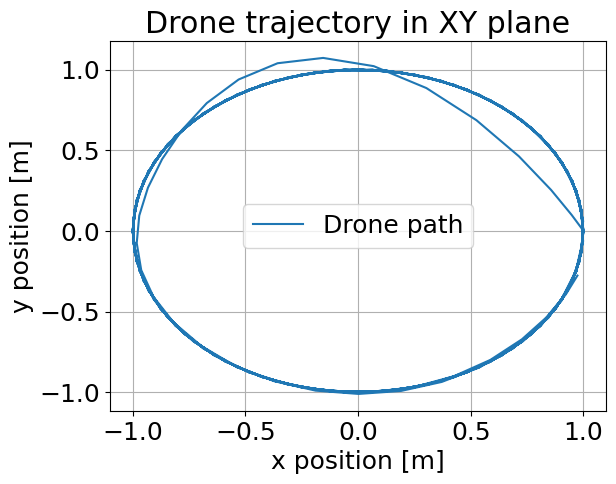

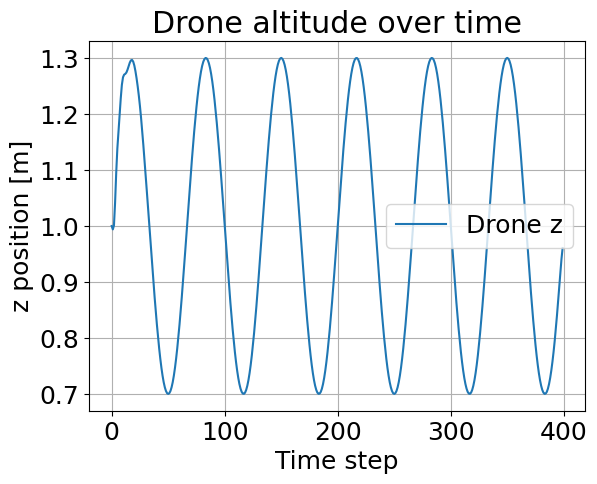

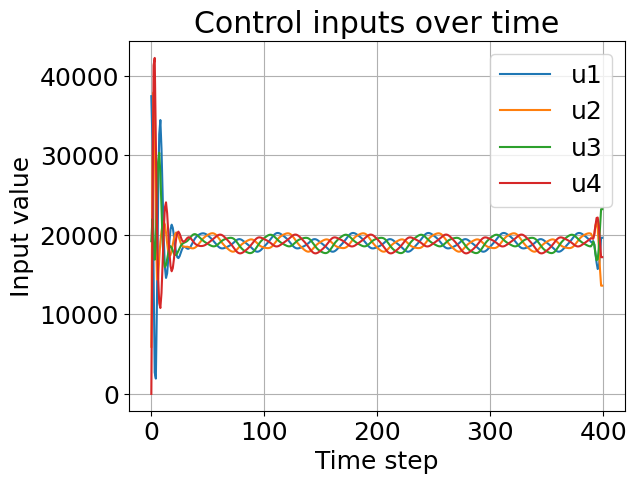

In [39]:
# === 1. Plot XY trajectory ===
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_sim['x'], x_sim['y'], label='Drone path')
ax.set_xlabel('x position [m]')
ax.set_ylabel('y position [m]')
ax.set_title('Drone trajectory in XY plane')
ax.legend()
ax.grid(True)
plt.show()

# === 2. Plot Z (altitude) over time ===
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(x_sim['z'], label='Drone z')
ax1.set_xlabel('Time step')
ax1.set_ylabel('z position [m]')
ax1.set_title('Drone altitude over time')
ax1.legend()
ax1.grid(True)
plt.show()

# === 3. Plot control inputs (u_sim) ===
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)

# Loop through each control input
for key in u_sim.keys():
    ax2.plot(u_sim[key], label=key)

ax2.set_xlabel('Time step')
ax2.set_ylabel('Input value')
ax2.set_title('Control inputs over time')
ax2.legend()
ax2.grid(True)
plt.show()



In [59]:
measurement_noise_stds = {'x': 0.1,
                          'y': 0.1,
                          'z': 0.1,
                          'phi': 0.1,
                          'theta': 0.1,
                          'psi': 0.1,
                          'phidot': 0.1,
                          'thetadot': 0.1,
                          'psidot': 0.1
                         }

<Axes: xlabel='Time', ylabel='x'>

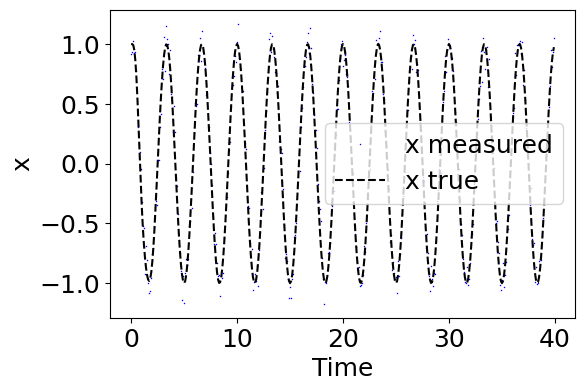

In [60]:
y_noisy = {key: y_sim[key] + np.random.normal(0, measurement_noise_stds[key], len(y_sim[key])) for key in y_sim.keys()}
plot_tme(t_sim, y_sim['x'], y_noisy['x'], label_var='x')


In [61]:
def rk4_discretize(f, x, u, dt):
    """
    Discretizes the continuous-time dynamics using the Runge-Kutta 4th order method (RK4).

    :param f: Function that defines the system dynamics (dx/dt = f(x, u))
              f should accept the current state `x` and input `u` and return the state derivatives.
    :param x: Current state (numpy array), representing the state at time t
    :param u: Control input (numpy array), control applied at time t
    :param dt: Time step (float), the discretization time step

    :return: Discretized state at time t+dt (numpy array)
    """

    # Step 1: Compute k1, the first estimate of the state change (function evaluation at time t)
    k1 = f(x, u)  # k1 is the rate of change at the current state

    # Step 2: Compute k2, estimate of state change at time t + dt/2, based on k1
    # Perturb x by half the step size (dt/2) in the direction of k1
    k2 = f(x + 0.5 * dt * k1, u)  # k2 is the rate of change at t + dt/2

    # Step 3: Compute k3, another estimate of state change at time t + dt/2, based on k2
    # Perturb x by half the step size (dt/2) in the direction of k2
    k3 = f(x + 0.5 * dt * k2, u)  # k3 is the rate of change at t + dt/2 (but using k2)

    # Step 4: Compute k4, estimate of state change at time t + dt, based on k3
    # Perturb x by the full time step (dt) in the direction of k3
    k4 = f(x + dt * k3, u)  # k4 is the rate of change at t + dt

    # Step 5: Compute the weighted sum of the estimates (k1, k2, k3, k4) to update x
    # The final estimate is a weighted average of all k's
    x_next = x + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

    return x_next
def jacobian_numerical(f, x0, u0, epsilon=0.001):

    # Get A
    Aj = []
    for i in range(len(f(x0,u0))):

        def f_scalar(x,u,i):
            x_new = f(x, u)
            return np.ravel(x_new)[i]

        j = scipy.optimize.approx_fprime(x0, f_scalar, epsilon, u0, i)
        Aj.append(j)

    # Get B
    Bj = []
    for i in range(len(f(x0,u0))):

        def f_scalar(u,x,i):
            x_new = f(x, u)
            return np.ravel(x_new)[i]

        j = scipy.optimize.approx_fprime(u0, f_scalar, epsilon, x0, i)
        Bj.append(j)

    return np.array(np.vstack(Aj)), np.array(np.vstack(Bj))

In [62]:
x0 = np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
u0 = np.array([17854, 17854, 17854, 17854])

def f_discrete(x, u):
    dt = 0.1
    return rk4_discretize(f, x, u, dt)
A, B = jacobian_numerical(f_discrete, x0, u0, epsilon=1e-6)

print('A:')
sp.pretty_print( np.round(A, 10) )

print('')
print('B:')
sp.pretty_print( np.round(B, 10) )

C, D = jacobian_numerical(h, x0, u0, epsilon=1e-6)

print('C:')
sp.pretty_print( np.round(C, 10) )

print('')
print('D:')
sp.pretty_print( np.round(D, 10) )

A:
 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 
    4.90494505e-02  0.00000000e+00  1.00000000e-01  0.00000000e+00 
   0.00000000e+00  0.00000000e+00  1.63498170e-03  0.00000000e+00] 
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -4.90494505e-02 
    0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-01 
   0.00000000e+00 -1.63498170e-03  0.00000000e+00  0.00000000e+00] 
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00 -2.46000000e-08 
   -2.46000000e-08  0.00000000e+00  0.00000000e+00  0.00000000e+00 
   9.99999999e-02 -1.00000000e-10 -1.00000000e-10  0.00000000e+00] 
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00 
    0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 
   0.00000000e+00  1.00000000e-01  0.00000000e+00  0.00000000e+00] 
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 
    1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 
   0.00000000e+00  0.00000000e+00  1.00000000

In [131]:
R = np.diag( list(measurement_noise_stds.values()) )**2

print('R:')
sp.pretty_print( np.round(R, 4) )
Q = np.diag([
    0.001, 0.001, 0.001,
    0.001, 0.001, 0.00001,
    0.001, 0.001, 0.4,
    0.001, 0.001, 0.00001
])


print('Q:')
sp.pretty_print( np.round(Q, 6) )

R:
[[0.01 0.   0.   0.   0.   0.   0.   0.   0.  ] 
 [0.   0.01 0.   0.   0.   0.   0.   0.   0.  ] 
 [0.   0.   0.01 0.   0.   0.   0.   0.   0.  ] 
 [0.   0.   0.   0.01 0.   0.   0.   0.   0.  ] 
 [0.   0.   0.   0.   0.01 0.   0.   0.   0.  ] 
 [0.   0.   0.   0.   0.   0.01 0.   0.   0.  ] 
 [0.   0.   0.   0.   0.   0.   0.01 0.   0.  ] 
 [0.   0.   0.   0.   0.   0.   0.   0.01 0.  ] 
 [0.   0.   0.   0.   0.   0.   0.   0.   0.01]]
Q:
[[1.e-03 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
                             0.e+00 0.e+00]                            
 [0.e+00 1.e-03 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
                             0.e+00 0.e+00]                            
 [0.e+00 0.e+00 1.e-03 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
                             0.e+00 0.e+00]                            
 [0.e+00 0.e+00 0.e+00 1.e-03 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
                             0.e+00 0.e+00]      

In [132]:
np.savez('ABCDRQ.npz', A=A, B=B, C=C, D=D, R=R, Q=Q)

In [133]:
import pandas

In [134]:
df_x = pandas.DataFrame(x_sim)
df_u = pandas.DataFrame(u_sim)
df_y = pandas.DataFrame(y_sim)
df_y_noisy = pandas.DataFrame(y_noisy)
df_t = pandas.DataFrame({'t': t_sim})

In [135]:
df_states = pandas.concat([df_t, df_x, df_u], axis=1)

In [136]:
df_measurements = pandas.concat([df_t, df_y], axis=1)
df_measurements_noisy = pandas.concat([df_t, df_y_noisy], axis=1)

In [137]:
loaded_arrays = np.load('ABCDRQ.npz')
A = loaded_arrays['A']
B = loaded_arrays['B']
C = loaded_arrays['C']
D = loaded_arrays['D']
R = loaded_arrays['R']
Q = loaded_arrays['Q']

In [138]:
print('A shape: ', A.shape)
print('B shape: ', B.shape)
print('C shape: ', C.shape)
print('D shape: ', D.shape)
print('R shape: ', R.shape)
print('Q shape: ', Q.shape)

A shape:  (12, 12)
B shape:  (12, 4)
C shape:  (9, 12)
D shape:  (9, 4)
R shape:  (9, 9)
Q shape:  (12, 12)


In [139]:
Y = np.vstack(df_measurements_noisy[['x', 'y', 'z', 'phi', 'theta', 'psi', 'phidot', 'thetadot', 'psidot']].values).T
print(Y.shape)
U = np.vstack(df_states[['u1', 'u2', 'u3', 'u4']].values).T
print(U.shape)
y_0 = Y[:, [0]]
print(y_0)
print('R shape: ', R.shape)
print('y_0 shape: ', y_0.shape)
print('[R x y_0] shape', (R@y_0).shape)
print('')
print('[R x y_0] = ')
R@y_0

(9, 400)
(4, 400)
[[ 0.91998828]
 [-0.08757816]
 [ 1.14337849]
 [ 0.0733566 ]
 [ 0.03178735]
 [ 0.09048839]
 [ 0.09858303]
 [ 0.12666664]
 [-0.10129738]]
R shape:  (9, 9)
y_0 shape:  (9, 1)
[R x y_0] shape (9, 1)

[R x y_0] = 


array([[ 0.00919988],
       [-0.00087578],
       [ 0.01143378],
       [ 0.00073357],
       [ 0.00031787],
       [ 0.00090488],
       [ 0.00098583],
       [ 0.00126667],
       [-0.00101297]])

In [140]:
def linear_discrete_kalman_forward_update(xhat_fp, P_fp, y, u, A, B, C, D, R, Q):
    """
    :param xhat_fm: prior state estimate
    :param P_fm: prior error covariance estimate
    :param y: measurements at this time step
    :param u: controls at this time step
    :param A,B,C,D: linear discrete time model
    :param R: measurement covariance matrix
    :param Q: process covariance matrix
    :return: current state estimate and error covariance matrix
    """
    I = np.array(np.eye(A.shape[0]))

    # predict the state and covariance for this time step given the previous estimate and the model
    xhat_fm = A@xhat_fp + B@u
    P_fm = A@P_fp@A.T + Q

    # Calculate optimal Kalman gain
    K_f = P_fm@C.T@np.linalg.pinv(C@P_fm@C.T + R)

    # If there are measurements: perform the update and predict steps
    if y is not None and not np.isnan(y).any():
        # estimate the measurements from the current state and the model
        yhat = C@xhat_fm + D@u

        # calculate the innovation
        innovation = (y - yhat)

        # Update state and covariance with optimal Kalman gain
        xhat_fp = xhat_fm + K_f@innovation
        P_fp = (I - K_f@C)@P_fm

    # If there are no measurements: cannot perform the update with innovation, so only predict forwards with the model
    else:
        xhat_fp = xhat_fm
        P_fp = (I - K_f@C)@P_fm

    return xhat_fp, P_fp

In [141]:
def linear_discrete_kalman_filter(x0, P0, Y, U, A, B, C, D, R, Q):
    """
    :param x0: initial state guess
    :param P0: initial state error covariance guess
    :param Y: array of all measurements
    :param U: array of all controls
    :param A,B,C,D: linear discrete time model
    :param R: measurement covariance matrix
    :param Q: process covariance matrix
    :return: state estimates and associated error covariance matrix
    """

    xhat_fp = x0
    P_fp = [P0]

    for i in range(Y.shape[1]):
        xhat_fp_i, P_fp_i = linear_discrete_kalman_forward_update(xhat_fp[:, [-1]], P_fp[-1], Y[:, [i]], U[:, [i]],
                                                                     A, B, C, D, R, Q)
        xhat_fp = np.hstack((xhat_fp, xhat_fp_i))
        P_fp.append(P_fp_i)

    # don't return that last element to keep size same as t
    return xhat_fp[:,1:], P_fp[1:]

In [142]:
x0 = np.atleast_2d([1]*A.shape[0]).T
print('x0 shape: ', x0.shape)

P0 = np.eye(A.shape[0])*100
print('P0 shape: ', P0.shape)

x0 shape:  (12, 1)
P0 shape:  (12, 12)


In [143]:
xhat_fp, P_fp = linear_discrete_kalman_filter(x0, P0, Y, U, A, B, C, D, R, Q)

<Axes: xlabel='Time', ylabel='psi'>

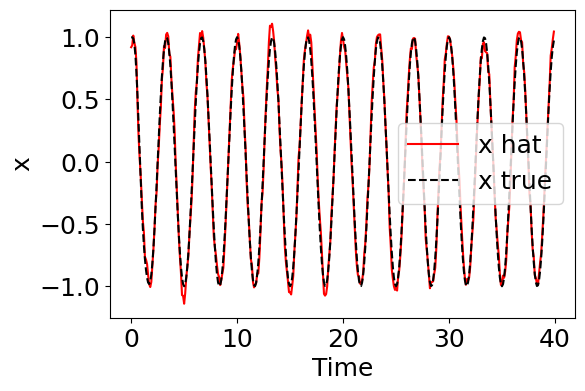

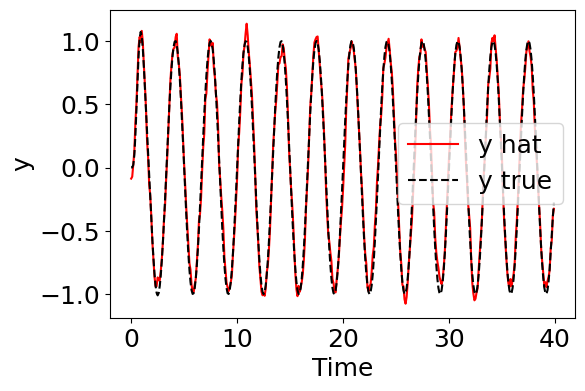

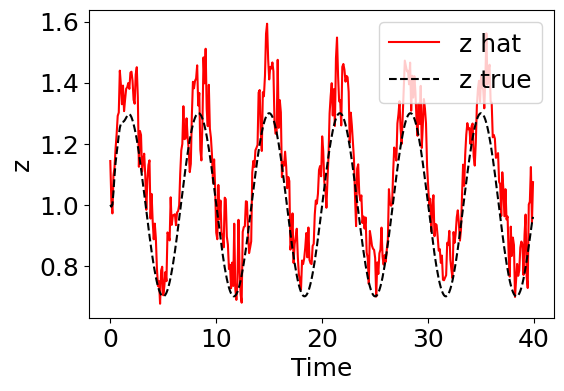

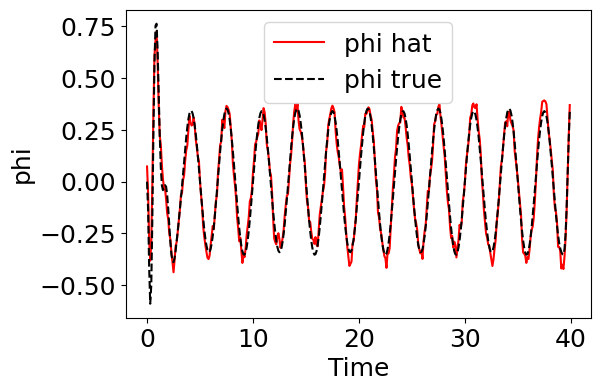

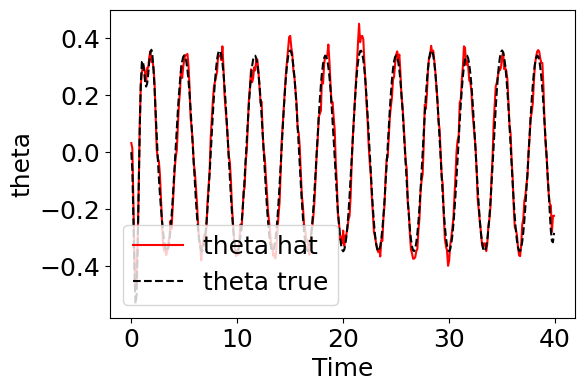

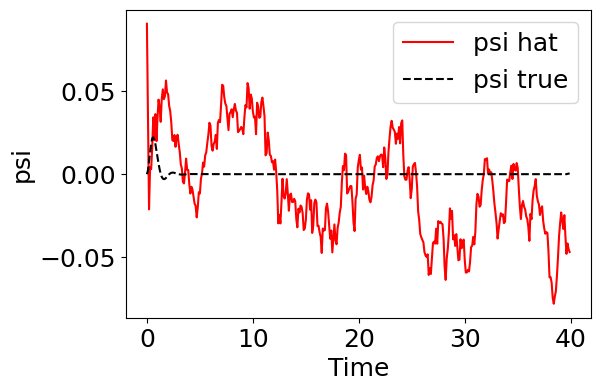

In [144]:
plot_tme(df_states.t, df_states['x'], None, estimated=xhat_fp[0,:], label_var='x')
plot_tme(df_states.t, df_states['y'], None, estimated=xhat_fp[1,:], label_var='y')
plot_tme(df_states.t, df_states['z'], None, estimated=xhat_fp[2,:], label_var='z')
plot_tme(df_states.t, df_states['phi'], None, estimated=xhat_fp[3,:], label_var='phi')
plot_tme(df_states.t, df_states['theta'], None, estimated=xhat_fp[4,:], label_var='theta')
plot_tme(df_states.t, df_states['psi'], None, estimated=xhat_fp[5,:], label_var='psi')